<a href="https://colab.research.google.com/github/1234Godwin/Alzheimer-Disease-Classification/blob/main/Alzheimer_Disease_Classification_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle

In [ ]:
import os
from google.colab import userdata

# Retrieve Kaggle credentials from Colab Secrets
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Kaggle CLI will now use these environment variables for authentication

# Create .kaggle directory if it doesn't exist (still good practice for Kaggle CLI)
!mkdir -p ~/.kaggle


In [ ]:
# Download the dataset
!kaggle datasets download -d aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented

Dataset URL: https://www.kaggle.com/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented
License(s): apache-2.0
 98% 388M/398M [00:00<00:00, 469MB/s]
100% 398M/398M [00:00<00:00, 549MB/s]


In [ ]:
# Unzip the dataset
import zipfile

zip_file_name = 'alzheimers-multiclass-dataset-equal-and-augmented.zip' # Make sure this matches the downloaded file name
extraction_dir = './alzheimers_multiclass_dataset'

if os.path.exists(zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir) # Extract to a new directory
    print(f"'{zip_file_name}' extracted to '{extraction_dir}'.")
else:
    print(f"Error: '{zip_file_name}' not found. Please check the dataset download step.")

'alzheimers-multiclass-dataset-equal-and-augmented.zip' extracted to './alzheimers_multiclass_dataset'.


In [ ]:
# List the contents of the extracted directory
!ls -R ./alzheimers_mri_dataset

ls: cannot access './alzheimers_mri_dataset': No such file or directory


In [ ]:
base_dir = './alzheimers_multiclass_dataset/combined_images' # Point to the directory containing images

if os.path.exists(base_dir):
    print(f"Contents of '{base_dir}':")
    for item in os.listdir(base_dir):
        print(item)

    # Optionally, if the output is too long, we can just print the first few levels
    # import glob
    # print("\nFirst few files/folders:")
    # for path in sorted(glob.glob(base_dir + '/**/*', recursive=True))[:20]:
    #     print(path)

else:
    print(f"Error: Image directory '{base_dir}' not found.")

Contents of './alzheimers_multiclass_dataset/combined_images':
MildDemented
VeryMildDemented
NonDemented
ModerateDemented


## Preparing Dataset for Deep Learning



In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
base_dir = './alzheimers_multiclass_dataset/combined_images'

# Create ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=VALIDATION_SPLIT
)

# Create ImageDataGenerator for validation (only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    validation_split=VALIDATION_SPLIT
)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print("Data generators created successfully.")

Found 35200 images belonging to 4 classes.
Found 8800 images belonging to 4 classes.
Data generators created successfully.


In [ ]:
from tensorflow.keras.applications import ResNet50

# Define the input shape for the model
# IMG_SIZE is already defined as (224, 224)
input_shape = IMG_SIZE + (3,)

# Load the pre-trained ResNet50 model, excluding the top (classification) layer
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

print("Pre-trained ResNet50 model loaded successfully, excluding the top layer.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Pre-trained ResNet50 model loaded successfully, excluding the top layer.


In [ ]:
from tensorflow.keras import layers, Model

# 1. Freeze the base model weights
base_model.trainable = False

# Get the output from the base model
x = base_model.output

# 3. Add a GlobalAveragePooling2D layer
x = layers.GlobalAveragePooling2D()(x)

# 4. Add a Dense layer with ReLU activation
x = layers.Dense(256, activation='relu')(x)

# 5. Add a final Dense layer for classification with softmax activation
num_classes = train_generator.num_classes # Get number of classes from the generator
predictions = layers.Dense(num_classes, activation='softmax')(x)

# 6. Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# 7. Compile the new model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Classification model built and compiled successfully.")
model.summary()

Classification model built and compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Reasoning**:
Now that the classification model has been built and compiled, the next step is to train it using the prepared data generators. I will use the `model.fit()` method, providing the training data and validation data generators, and setting a reasonable number of epochs.



In [ ]:
history = model.fit(
    train_generator,
    epochs=5, # You can adjust the number of epochs
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 522s 461ms/step - accuracy: 0.3022 - loss: 1.4008 - val_accuracy: 0.3870 - val_loss: 1.3012
Epoch 2/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 503s 457ms/step - accuracy: 0.3682 - loss: 1.3090 - val_accuracy: 0.4269 - val_loss: 1.2526
Epoch 3/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 510s 463ms/step - accuracy: 0.3985 - loss: 1.2689 - val_accuracy: 0.4535 - val_loss: 1.2136
Epoch 4/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 503s 458ms/step - accuracy: 0.4275 - loss: 1.2369 - val_accuracy: 0.3882 - val_loss: 1.2501
Epoch 5/5
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 503s 457ms/step - accuracy: 0.4369 - loss: 1.2148 - val_accuracy: 0.4723 - val_loss: 1.1619
Model training complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After running the cell above and authorizing Google Drive access, the following cell will save your `history_df` to a CSV file in your Drive.

In [ ]:
import os
import pandas as pd

# Convert the history object to a pandas DataFrame
history_df = pd.DataFrame(history.history)

# Define the path to save the CSV in Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/' # You can change this path as needed

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Save the history to a CSV file in Google Drive
history_file_path = os.path.join(drive_path, 'training_history.csv')
history_df.to_csv(history_file_path, index=False)

print(f"Training history saved to '{history_file_path}' in your Google Drive.")

Training history saved to '/content/drive/My Drive/Colab Notebooks/training_history.csv' in your Google Drive.


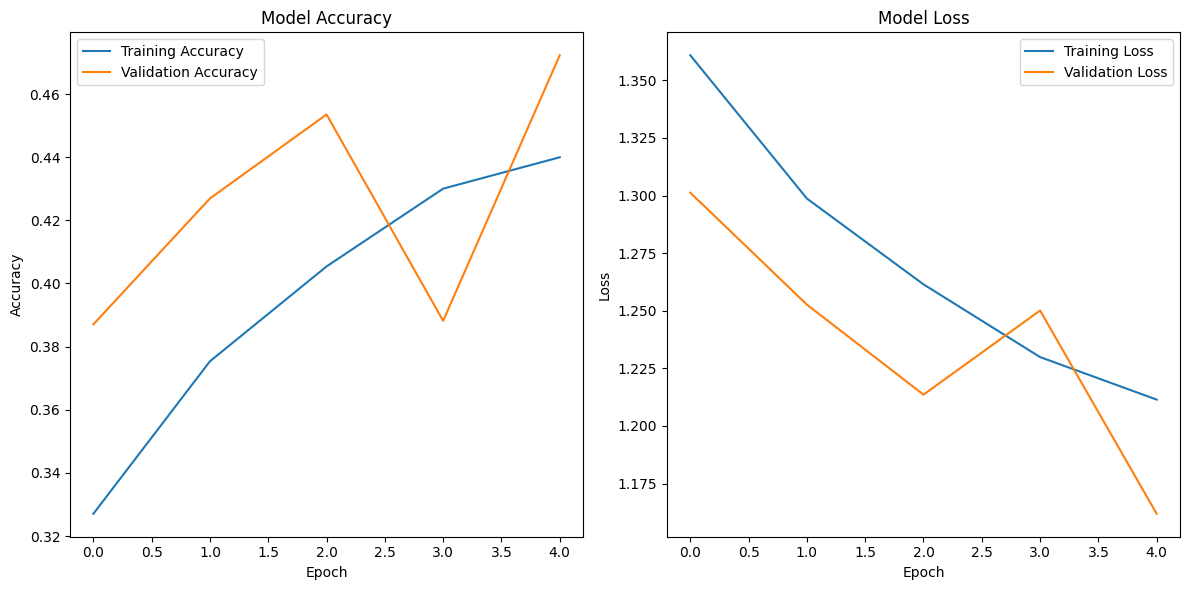

Training and validation accuracy and loss curves plotted.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print("Training and validation accuracy and loss curves plotted.")

In [ ]:
# Unfreeze the last 30 layers of the base model
# Keeping earlier layers frozen to retain learned low-level features
for layer in base_model.layers[:-30]:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

print("Last 30 layers of ResNet50 base model unfrozen for fine-tuning.")

# Print a summary to verify which layers are trainable
print("\nBase model summary after unfreezing layers:")
base_model.summary()

Last 30 layers of ResNet50 base model unfrozen for fine-tuning.

Base model summary after unfreezing layers:


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Recompile the model after unfreezing layers
# It's common practice to use a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5), # A smaller learning rate is usually better for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with unfrozen layers and a lower learning rate.")
model.summary()

Model recompiled with unfrozen layers and a lower learning rate.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 14,975,748 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [ ]:
history_fine_tune = model.fit(
    train_generator,
    epochs=10, # Additional epochs for fine-tuning
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

print("Fine-tuning training complete.")

Epoch 1/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 527s 479ms/step - accuracy: 0.7283 - loss: 0.6047 - val_accuracy: 0.7589 - val_loss: 0.5532
Epoch 2/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 537s 488ms/step - accuracy: 0.7417 - loss: 0.5784 - val_accuracy: 0.7903 - val_loss: 0.4819
Epoch 3/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 527s 479ms/step - accuracy: 0.7458 - loss: 0.5701 - val_accuracy: 0.7843 - val_loss: 0.4973
Epoch 4/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 532s 484ms/step - accuracy: 0.7590 - loss: 0.5488 - val_accuracy: 0.8197 - val_loss: 0.4172
Epoch 5/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 534s 485ms/step - accuracy: 0.7536 - loss: 0.5569 - val_accuracy: 0.8086 - val_loss: 0.4413
Epoch 6/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 529s 481ms/step - accuracy: 0.7725 - loss: 0.5214 - val_accuracy: 0.7732 - val_loss: 0.5451
Epoch 7/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 525s 477ms/step - accuracy: 0.7723 - loss: 0.5156 - val_accuracy: 0.8023 - val_loss: 0.4715
Epoch 8/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 532s 483ms/step - ac

In [ ]:
import os
import pandas as pd

# Convert the history object to a pandas DataFrame
history_fine_tune_df = pd.DataFrame(history_fine_tune.history)

# Define the path to save the CSV in Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/' # You can change this path as needed

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Save the history to a CSV file in Google Drive
history_fine_tune_file_path = os.path.join(drive_path, 'training_history_fine_tune.csv')
history_fine_tune_df.to_csv(history_fine_tune_file_path, index=False)

print(f"Training history saved to '{history_fine_tune_file_path}' in your Google Drive.")

Training history saved to '/content/drive/My Drive/Colab Notebooks/training_history_fine_tune.csv' in your Google Drive.


In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.8332 - loss: 0.3827
Validation Loss: 0.3785
Validation Accuracy: 0.8358


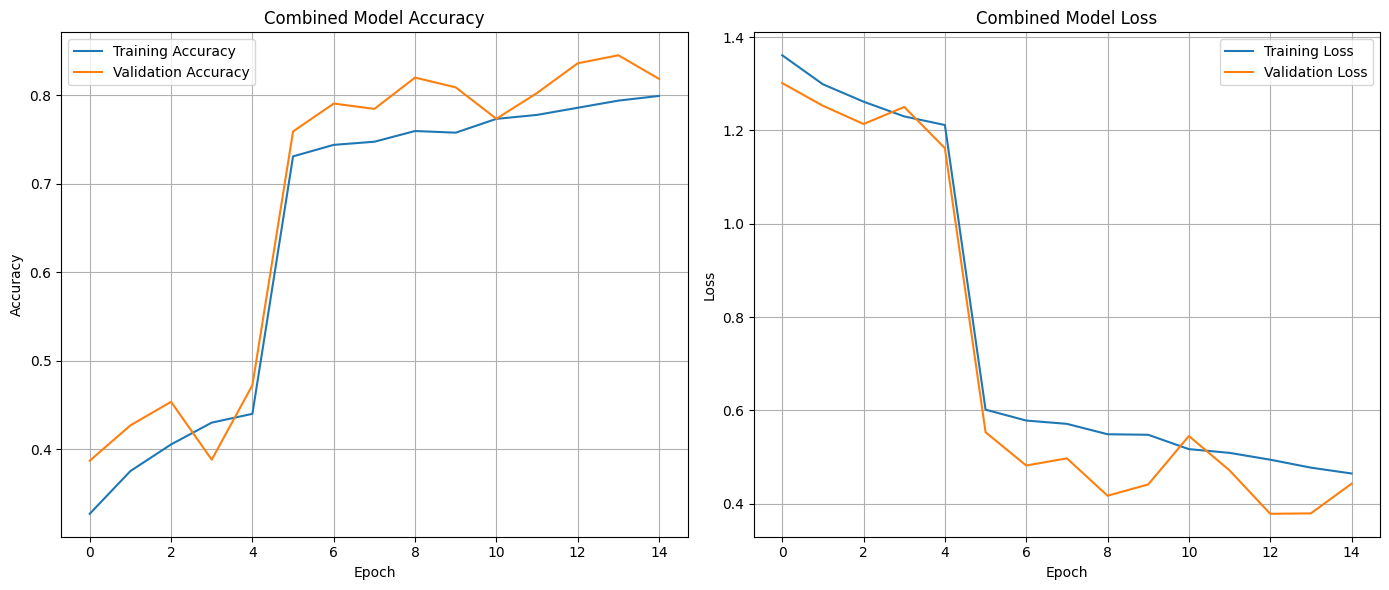

Combined training and validation accuracy and loss curves plotted.


In [ ]:
# Combine the training history DataFrames
total_epochs_initial = len(history_df)
history_fine_tune_df['epoch'] = range(total_epochs_initial, total_epochs_initial + len(history_fine_tune_df))
history_fine_tune_df = history_fine_tune_df.set_index('epoch')

# Reset index of history_df to align before concat if 'epoch' column is not explicitly present
history_df_indexed = history_df.reset_index().rename(columns={'index': 'epoch'})

combined_history_df = pd.concat([history_df_indexed, history_fine_tune_df])

# Plotting the combined history
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(combined_history_df['accuracy'], label='Training Accuracy')
plt.plot(combined_history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Combined Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(combined_history_df['loss'], label='Training Loss')
plt.plot(combined_history_df['val_loss'], label='Validation Loss')
plt.title('Combined Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Combined training and validation accuracy and loss curves plotted.")